# Divisão e Visualização de Dados
Este notebook realiza a divisão dos dados em conjuntos de treino, validação e teste, além de fornecer ferramentas para visualização dos dados.

In [20]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F


# Caminhos
ROOT_DIR = "frames"  # Pasta com os frames
LABELS_FILE = "OSATS_clean_multiclasses.xlsx"  # Arquivo com os rótulos

# Proporções para divisão
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Transformações
mean = [0.4434, 0.4797, 0.5037]
std = [0.1893, 0.1636, 0.1239]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class VideoFrameDataset(Dataset):
    def __init__(self, root_dir, labels_file, video_ids, transform=None):
        self.root_dir = root_dir
        self.labels = pd.read_excel(labels_file)
        self.video_ids = video_ids
        self.transform = transform
        self.data = []

        for video_id in self.video_ids:
            video_frames_dir = os.path.join(self.root_dir, video_id)
            if os.path.exists(video_frames_dir):
                for frame_file in os.listdir(video_frames_dir):
                    if frame_file.endswith(('.jpg', '.png', '.jpeg')):
                        frame_path = os.path.join(video_frames_dir, frame_file)
                        # Obter os valores das 8 colunas
                        labels = self.labels.loc[self.labels['VIDEO'] == video_id, [
                            'OSATS_RESPECT', 'OSATS_MOTION', 'OSATS_INSTRUMENT',
                            'OSATS_SUTURE', 'OSATS_FLOW', 'OSATS_KNOWLEDGE',
                            'OSATS_PERFORMANCE', 'OSATS_FINAL_QUALITY'
                        ]].values[0]
                        self.data.append((frame_path, labels))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame_path, labels = self.data[idx]
        image = Image.open(frame_path)
        if self.transform:
            image = self.transform(image)
        # Converter os rótulos para tensor
        labels = torch.tensor(labels, dtype=torch.float32)
        return image, labels

def split_data_by_video(labels_file, train_ratio, val_ratio, test_ratio):
    """
    Divide os vídeos em conjuntos de treino, validação e teste de forma aleatória.

    Args:
        labels_file (str): Caminho para o arquivo Excel contendo os rótulos.
        train_ratio (float): Proporção de dados para o conjunto de treino.
        val_ratio (float): Proporção de dados para o conjunto de validação.
        test_ratio (float): Proporção de dados para o conjunto de teste.

    Returns:
        tuple: Listas de IDs de vídeos para treino, validação e teste.
    """
    # Carregar os rótulos
    labels_df = pd.read_excel(labels_file)
    
    # Obter todos os IDs de vídeos
    video_ids = labels_df['VIDEO'].tolist()
    
    # Dividir em treino e restante
    train_ids, temp_ids = train_test_split(video_ids, test_size=(1 - train_ratio), random_state=42)
    
    # Dividir o restante em validação e teste
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_ids, test_ids = train_test_split(temp_ids, test_size=(1 - val_ratio_adjusted), random_state=42)
    
    return train_ids, val_ids, test_ids

def create_dataloaders(root_dir, labels_file, train_ids, val_ids, test_ids, transform, batch_size=32):
    train_dataset = VideoFrameDataset(root_dir, labels_file, train_ids, transform)
    val_dataset = VideoFrameDataset(root_dir, labels_file, val_ids, transform)
    test_dataset = VideoFrameDataset(root_dir, labels_file, test_ids, transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Dividir os dados por vídeo
train_ids, val_ids, test_ids = split_data_by_video(LABELS_FILE, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Criar os DataLoaders
train_loader, val_loader, test_loader = create_dataloaders(ROOT_DIR, LABELS_FILE, train_ids, val_ids, test_ids, transform)

# Exemplo: verificar tamanhos
print(f"Treino: {len(train_loader.dataset)} frames")
print(f"Validação: {len(val_loader.dataset)} frames")
print(f"Teste: {len(test_loader.dataset)} frames")

Treino: 83931 frames
Validação: 18142 frames
Teste: 18269 frames


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9999999611377716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9999999611377716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..1.000000043964386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9999999611377716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9999999813079834].


Visualizando dados de treino:


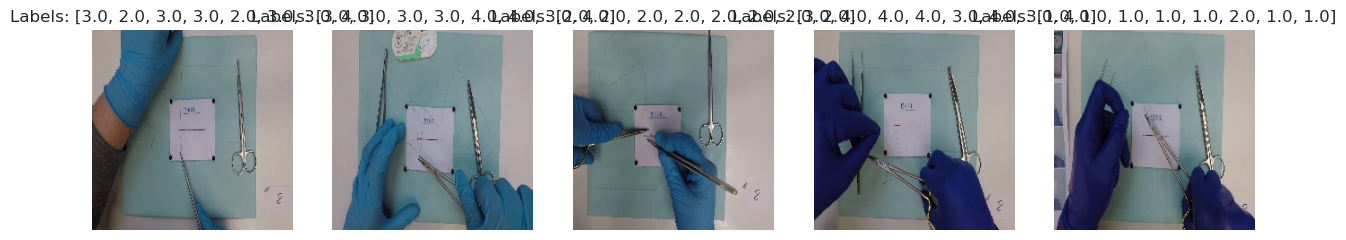

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..1.000000043964386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9999999611377716].


Visualizando dados de validação:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.8980392411947251].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9999999611377716].


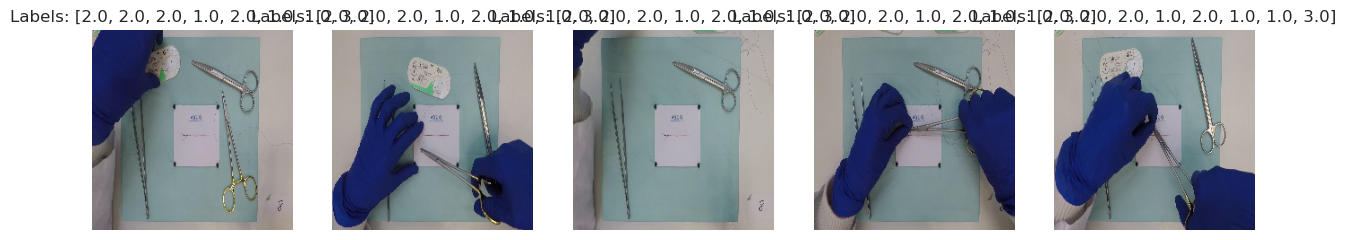

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9882353269100189].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9999999611377716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..1.000000043964386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9999999611377716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..1.000000043964386].


Visualizando dados de teste:


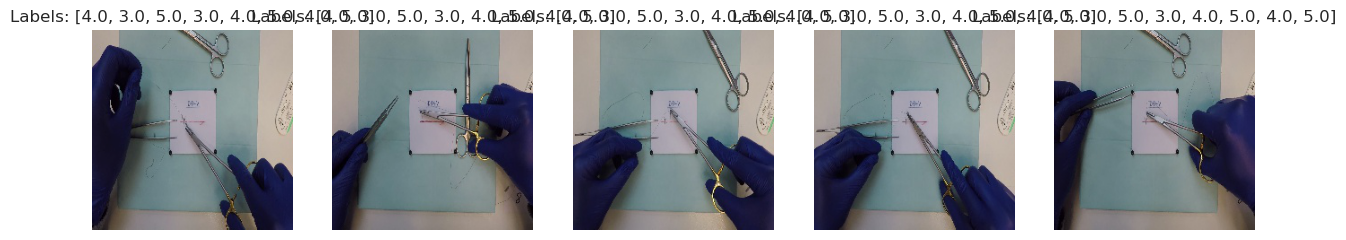

In [21]:
def visualize_data(loader, num_images=5):
    images, labels = next(iter(loader))
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.axis('off')
        plt.imshow(images[i].permute(1, 2, 0).numpy() * std + mean)
        # Exibir os 8 rótulos como uma lista
        plt.title(f"Labels: {labels[i].tolist()}")
    plt.show()

# Visualizar dados de treino
print("Visualizando dados de treino:")
visualize_data(train_loader)

# Visualizar dados de validação
print("Visualizando dados de validação:")
visualize_data(val_loader)

# Visualizar dados de teste
print("Visualizando dados de teste:")
visualize_data(test_loader)

In [22]:
def visualize_dataset_split(train_loader, val_loader, test_loader):
    print(f"Quantidade de casos de Treino: {len(train_loader.dataset)}")
    print(f"Quantidade de casos de Validação: {len(val_loader.dataset)}")
    print(f"Quantidade de casos de Teste: {len(test_loader.dataset)}")

    for loader, name in zip([train_loader, val_loader, test_loader], ["Treino", "Validação", "Teste"]):
        x, y = next(iter(loader))
        print(f"\n{name}:")
        print(f"Shape tensor batch, input: {x.shape}, output: {y.shape}")
        print(f"Valor máximo no batch: {torch.max(x)} Valor mínimo no batch: {torch.min(x)}")
        x = x.detach().numpy()
        print(f"Valor máximo após conversão para numpy: {np.max(x)} Valor mínimo: {np.min(x)}")
        print(f"Rótulos no batch: {y}")

# Exemplo de uso
visualize_dataset_split(train_loader, val_loader, test_loader)

Quantidade de casos de Treino: 83931
Quantidade de casos de Validação: 18142
Quantidade de casos de Teste: 18269

Treino:
Shape tensor batch, input: torch.Size([32, 3, 224, 224]), output: torch.Size([32, 8])
Valor máximo no batch: 4.005649566650391 Valor mínimo no batch: -4.065375804901123
Valor máximo após conversão para numpy: 4.005649566650391 Valor mínimo: -4.065375804901123
Rótulos no batch: tensor([[4., 3., 4., 3., 4., 4., 3., 4.],
        [1., 2., 1., 1., 2., 1., 1., 1.],
        [4., 4., 4., 4., 4., 5., 4., 4.],
        [3., 2., 3., 3., 2., 3., 2., 3.],
        [3., 3., 3., 2., 2., 2., 2., 1.],
        [1., 2., 1., 1., 2., 1., 1., 1.],
        [3., 1., 2., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 2., 1., 1.],
        [4., 4., 4., 5., 4., 5., 3., 3.],
        [3., 4., 4., 4., 3., 4., 3., 4.],
        [3., 3., 4., 4., 4., 5., 4., 3.],
        [4., 4., 4., 4., 4., 5., 4., 4.],
        [2., 1., 2., 2., 2., 2., 2., 2.],
        [3., 4., 4., 4., 3., 5., 4., 4.],
        [2.,

-----------------------------------Treino-----------------------------------
Total de casos em Treino: 83931
Classes: [1. 2. 3. 4. 5.]
Frequências: [183246 153795 181827 132482  20098]
Total: 671448


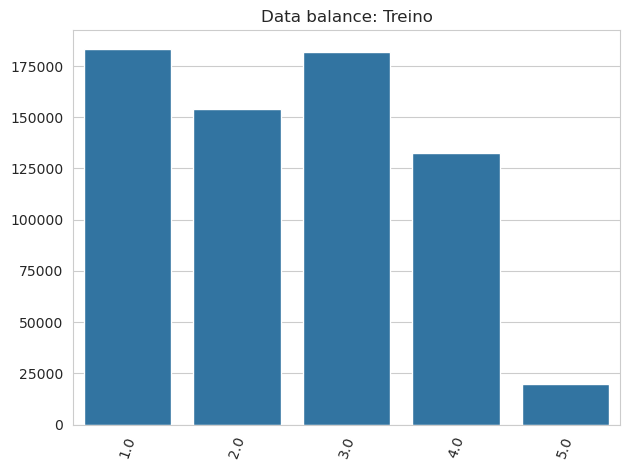

-----------------------------------Validação-----------------------------------
Total de casos em Validação: 18142
Classes: [1. 2. 3. 4. 5.]
Frequências: [44320 32424 30038 29214  9140]
Total: 145136


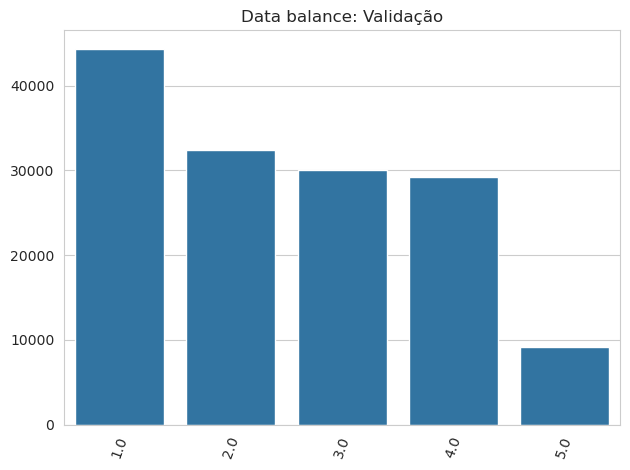

-----------------------------------Teste-----------------------------------
Total de casos em Teste: 18269
Classes: [1. 2. 3. 4. 5.]
Frequências: [45539 40275 26500 21949 11889]
Total: 146152


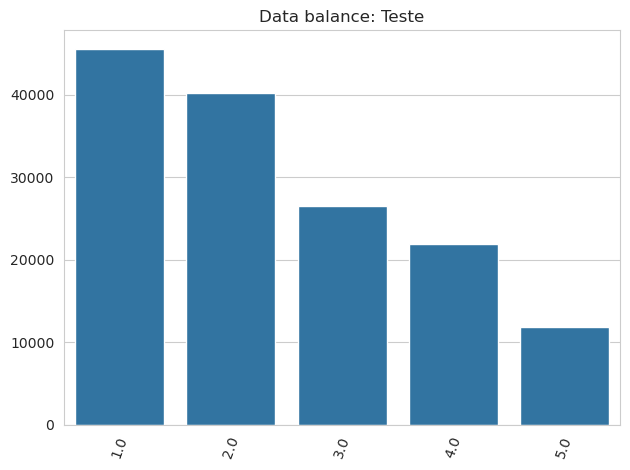

In [23]:
def visualize_data_balance(loader, titulo):
    all_labels = []
    for _, labels in loader:
        all_labels.extend(labels.numpy())

    sns.set_style('whitegrid')
    print(f"Total de casos em {titulo}: {len(all_labels)}")

    x, y = np.unique(all_labels, return_counts=True)

    print("Classes:", x)
    print("Frequências:", y)
    print("Total:", np.sum(y))

    grafico = sns.barplot(x=x, y=y)
    grafico.set_title(f'Data balance: {titulo}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()

# Exemplo de uso
print("-----------------------------------Treino-----------------------------------")
visualize_data_balance(train_loader, 'Treino')

print("-----------------------------------Validação-----------------------------------")
visualize_data_balance(val_loader, 'Validação')

print("-----------------------------------Teste-----------------------------------")
visualize_data_balance(test_loader, 'Teste')

## MODEL 

In [24]:
from torchinfo import summary

BATCH_SIZE = 32


cuda = torch.device("cuda")
torch.cuda.reset_peak_memory_stats()  
torch.cuda.empty_cache()

print(torch.cuda.memory_summary(device=0, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  17216 KiB |  17216 KiB |  37347 GiB |  37347 GiB |
|       from large pool |  16640 KiB |  16640 KiB |  37296 GiB |  37296 GiB |
|       from small pool |    576 KiB |    576 KiB |     50 GiB |     50 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  17216 KiB |  17216 KiB |  37347 GiB |  37347 GiB |
|       from large pool |  16640 KiB |  16640 KiB |  37296 GiB |

In [25]:
class CNNModel2D(nn.Module):
    def __init__(self, num_outputs=8):  # Alterado para 8 saídas
        super(CNNModel2D, self).__init__()
        
        # Sequential1: First Conv Layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduz (224, 224) -> (112, 112)
        )
        
        # Sequential2: Second Conv Layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduz (112, 112) -> (56, 56)
        )
        
        # Sequential3: Third Conv Layer
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduz (56, 56) -> (28, 28)
        )
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Reduz (28, 28) -> (1, 1)
        
        # Fully Connected Layer
        self.fc = nn.Linear(in_features=64, out_features=num_outputs)  # Alterado para 8 saídas
    
    def forward(self, x):
        # Pass through the layers
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # Global Average Pooling
        out = self.global_avg_pool(out)
        out = out.view(out.size(0), -1)  # Flatten (batch_size, 64, 1, 1) -> (batch_size, 64)
        
        # Fully Connected Layer
        out = self.fc(out)
        return out
    
# Instanciar o modelo
model = CNNModel2D(num_outputs=8)
# Resumo do modelo
summary(model, input_size=(BATCH_SIZE, 3, 224, 224), device=cuda)
# Verificar uso de memória

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel2D                               [32, 8]                   --
├─Sequential: 1-1                        [32, 16, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 16, 224, 224]        448
│    └─ReLU: 2-2                         [32, 16, 224, 224]        --
│    └─MaxPool2d: 2-3                    [32, 16, 112, 112]        --
├─Sequential: 1-2                        [32, 32, 56, 56]          --
│    └─Conv2d: 2-4                       [32, 32, 112, 112]        4,640
│    └─ReLU: 2-5                         [32, 32, 112, 112]        --
│    └─MaxPool2d: 2-6                    [32, 32, 56, 56]          --
├─Sequential: 1-3                        [32, 64, 28, 28]          --
│    └─Conv2d: 2-7                       [32, 64, 56, 56]          18,496
│    └─ReLU: 2-8                         [32, 64, 56, 56]          --
│    └─MaxPool2d: 2-9                    [32, 64, 28, 28]          --
├─Adapt

In [34]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, save_path):
    model.to(device)
    
    # Listas para armazenar métricas
    train_losses = []
    train_rmse = []  # RMSE para treino
    val_losses = []
    val_rmse = []  # RMSE para validação
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Treinamento
        model.train()
        running_loss = 0.0
        total_samples = 0
        total_rmse = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Estatísticas
            running_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
            
            # Calcular RMSE para o batch
            batch_rmse = torch.sqrt(torch.mean((outputs - labels) ** 2)).item()
            total_rmse += batch_rmse * inputs.size(0)
        
        epoch_loss = running_loss / total_samples
        epoch_rmse = total_rmse / total_samples
        train_losses.append(epoch_loss)
        train_rmse.append(epoch_rmse)
        print(f"Treino - Loss: {epoch_loss:.4f}, RMSE: {epoch_rmse:.4f}")
        
        # Validação
        model.eval()
        val_loss = 0.0
        val_total_samples = 0
        val_total_rmse = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_total_samples += inputs.size(0)
                
                # Calcular RMSE para o batch
                batch_rmse = torch.sqrt(torch.mean((outputs - labels) ** 2)).item()
                val_total_rmse += batch_rmse * inputs.size(0)
        
        val_loss /= val_total_samples
        val_rmse_epoch = val_total_rmse / val_total_samples
        val_losses.append(val_loss)
        val_rmse.append(val_rmse_epoch)
        print(f"Validação - Loss: {val_loss:.4f}, RMSE: {val_rmse_epoch:.4f}")
    
    # Salvar o modelo treinado
    torch.save(model.state_dict(), save_path)
    print(f"Modelo salvo em: {save_path}")
    
    # Retornar métricas para plotagem
    return train_losses, train_rmse, val_losses, val_rmse

Epoch 1/2
Treino - Loss: 1.1009, RMSE: 1.0378
Validação - Loss: 0.9770, RMSE: 0.9195
Epoch 2/2
Treino - Loss: 0.5938, RMSE: 0.7649
Validação - Loss: 0.7096, RMSE: 0.7862
Modelo salvo em: Models/Task2/modelo_treinado_CNNModel2D_10_epochs.pth


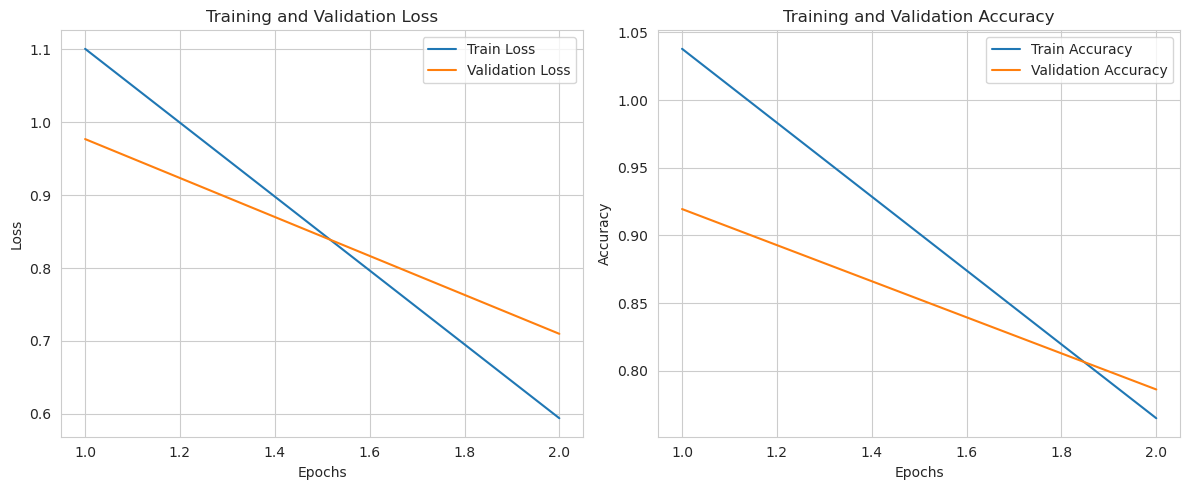

In [35]:
# Configurações
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel2D(num_outputs=8)  # Substitua pelo modelo desejado
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 2
save_path = "Models/Task2/modelo_treinado_CNNModel2D_10_epochs.pth"

# Treinar o modelo

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs, device, save_path
)

# Plotar os gráficos
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, test_loader, device):
    model.to(device)
    model.eval()
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Armazenar previsões e rótulos
            all_predictions.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Converter para arrays numpy
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Calcular métricas
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_labels, all_predictions)
    
    print(f"Teste - MSE: {mse:.4f}")
    print(f"Teste - RMSE: {rmse:.4f}")
    print(f"Teste - MAE: {mae:.4f}")
    
    # Exibir métricas para cada saída
    for i in range(all_labels.shape[1]):
        mse_col = mean_squared_error(all_labels[:, i], all_predictions[:, i])
        rmse_col = np.sqrt(mse_col)
        mae_col = mean_absolute_error(all_labels[:, i], all_predictions[:, i])
        print(f"Coluna {i + 1}:")
        print(f"  MSE: {mse_col:.4f}")
        print(f"  RMSE: {rmse_col:.4f}")
        print(f"  MAE: {mae_col:.4f}")

    ## RELATORIO DE CLASSIFICAÇÃO
    from sklearn.metrics import classification_report
    


    # RELATORIO DE CLASSIFICAÇÃO
    y_true = np.argmax(all_labels, axis=1)
    y_pred = np.argmax(all_predictions, axis=1)
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("\nRelatório de Classificação:")
    print(report_df)

    # matrriz de confusão
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title('Matriz de Confusão')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    


/tmp/ipykernel_60146/1696312925.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Models/Task2/modelo_treinado_CNNModel2D_10_epochs.pth")

Teste - MSE: 0.9353
Teste - RMSE: 0.9671
Teste - MAE: 0.7439
Coluna 1:
  MSE: 0.4769
  RMSE: 0.6906
  MAE: 0.5845
Coluna 2:
  MSE: 0.9085
  RMSE: 0.9532
  MAE: 0.7442
Coluna 3:
  MSE: 1.0549
  RMSE: 1.0271
  MAE: 0.7686
Coluna 4:
  MSE: 0.7850
  RMSE: 0.8860
  MAE: 0.6792
Coluna 5:
  MSE: 1.2687
  RMSE: 1.1264
  MAE: 0.8532
Coluna 6:
  MSE: 1.3690
  RMSE: 1.1700
  MAE: 0.9208
Coluna 7:
  MSE: 0.7336
  RMSE: 0.8565
  MAE: 0.6532
Coluna 8:
  MSE: 0.8859
  RMSE: 0.9412
  MAE: 0.7477

Relatório de Classificação:
              precision    recall  f1-score      support
0              0.721291  0.415945  0.527625  10963.00000
1              0.000000  0.000000  0.000000    912.00000
2              0.193154  0.043276  0.070709   3651.00000
3              0.000000  0.000000  0.000000    925.00000
4              0.000000  0.000000  0.000000      0.00000
5              0.048268  0.212321  0.078655   1818.00000
6              0.000000  0.000000  0.000000      0.00000
7              0.000000  0.000

/home/cid34senhas/miniconda3/envs/deepL2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/deepL2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/deepL2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

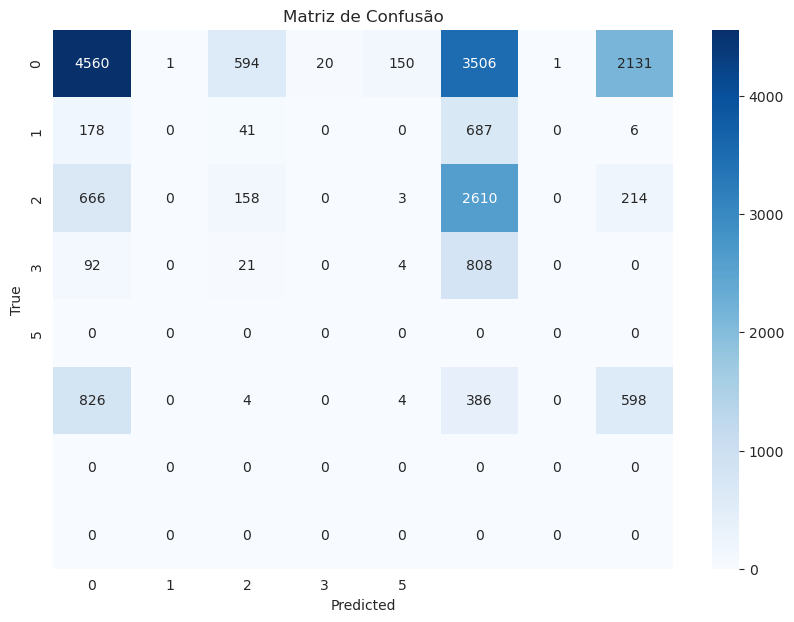

In [41]:
# Carregar o modelo treinado
model = CNNModel2D(num_outputs=8)  
model.load_state_dict(torch.load("Models/Task2/modelo_treinado_CNNModel2D_10_epochs.pth"))

# Avaliar o modelo
evaluate_model(model, test_loader, device)